In [ ]:
### Install Requirement
!pip install -r requirements.txt


In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline


import gc
import os
import logging
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



warnings.filterwarnings('ignore')


In [2]:
from util_feature import *
from util_model import *
print("ok")

np.

os.getcwd D:\_devs\Python01\gitdev\da\da
imported <module 'evolutionary_search' from 'D:\\_devs\\Python01\\ana3\\envs\\py36intel\\lib\\site-packages\\evolutionary_search\\__init__.py'>
imported <module 'lightgbm' from 'D:\\_devs\\Python01\\ana3\\envs\\py36intel\\lib\\site-packages\\lightgbm\\__init__.py'>
kmodes None No module named 'kmodes'
imported <module 'catboost' from 'D:\\_devs\\Python01\\ana3\\envs\\py36intel\\lib\\site-packages\\catboost\\__init__.py'>
tpot None No module named 'tpot'
os.getcwd D:\_devs\Python01\gitdev\da\da
ok


# Data Loading, basic profiling

In [3]:
folder = os.getcwd() + "/"



In [4]:
df = pd.read_csv(folder + '/data/address_matching_data.csv')
df.head(5)



,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
0,1204#1207,0.666667,0.666667,0.400000,0.526316,?,?,?,?,?,...,?,?,?,?,1.0,1.0,m,m,s,1
1,1272#1279,0.666667,0.666667,0.411765,0.444444,?,?,?,?,?,...,?,?,?,?,1.0,1.0,m,m,s,1
2,6258#6259,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,...,1.0,1.0,?,?,1.0,1.0,s,m,s,1
3,16076#16077,0.565476,0.333333,0.260870,0.189189,?,?,?,?,?,...,1.0,1.0,?,?,0.0,0.0,s,m,n,-1
4,2666#2671,0.666667,0.666667,0.500000,0.518519,1,1,1,1,1,...,1.0,1.0,?,?,1.0,1.0,s,m,s,1


In [5]:
df.describe()


,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,is_match
count,28235.000000,28235.000000,28235.000000,28235.000000,28235.00000
mean,0.628171,0.563277,0.537006,0.509530,0.43524
std,0.304767,0.369004,0.324820,0.372265,0.90033
min,0.000000,0.000000,0.000000,0.000000,-1.00000
25%,0.363387,0.222222,0.243243,0.142857,-1.00000
50%,0.666667,0.666667,0.476190,0.483871,1.00000
75%,1.000000,1.000000,0.875000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000


In [6]:
df.columns, df.dtypes

(Index(['id', 'name_levenshtein_simple', 'name_trigram_simple',
        'name_levenshtein_term', 'name_trigram_term', 'city_levenshtein_simple',
        'city_trigram_simple', 'city_levenshtein_term', 'city_trigram_term',
        'zip_levenshtein_simple', 'zip_trigram_simple', 'zip_levenshtein_term',
        'zip_trigram_term', 'street_levenshtein_simple',
        'street_trigram_simple', 'street_levenshtein_term',
        'street_trigram_term', 'website_levenshtein_simple',
        'website_trigram_simple', 'website_levenshtein_term',
        'website_trigram_term', 'phone_levenshtein', 'phone_trigram',
        'fax_levenshtein', 'fax_trigram', 'street_number_levenshtein',
        'street_number_trigram', 'phone_equality', 'fax_equality',
        'street_number_equality', 'is_match'],
       dtype='object'), id                             object
 name_levenshtein_simple       float64
 name_trigram_simple           float64
 name_levenshtein_term         float64
 name_trigram_term      

In [7]:
### Pandas Profiling for features
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import pandas_profiling as pp
profile =  df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output.html")


colexclude = profile.get_rejected_variables(threshold=0.98)
colexclude 



In [8]:
colexclude = profile.get_rejected_variables(threshold=0.98)
colexclude 

['name_trigram_simple']

# Column selection by type

In [11]:
colid = "id"
colnum = ['name_levenshtein_simple', 'name_trigram_simple',
        'name_levenshtein_term', 'name_trigram_term', 'city_levenshtein_simple',
        'city_trigram_simple', 'city_levenshtein_term', 'city_trigram_term',
        'zip_levenshtein_simple', 'zip_trigram_simple', 'zip_levenshtein_term',
        'zip_trigram_term', 'street_levenshtein_simple',
        'street_trigram_simple', 'street_levenshtein_term',
        'street_trigram_term', 'website_levenshtein_simple',
        'website_trigram_simple', 'website_levenshtein_term',
        'website_trigram_term', 'phone_levenshtein', 'phone_trigram',
        'fax_levenshtein', 'fax_trigram', 'street_number_levenshtein',
        'street_number_trigram']

colcat = [ 'phone_equality', 'fax_equality',
          'street_number_equality']
coltext = []

coly = "is_match"


colall = colnum + colcat + coltext

"""

dfnum, dfcat, dfnum_bin, 
dfnum_binhot,  dfcat_hot

colnum, colcat, coltext, 
colnum_bin, colnum_binhot,  

"""

print(colall )


['name_levenshtein_simple', 'name_trigram_simple', 'name_levenshtein_term', 'name_trigram_term', 'city_levenshtein_simple', 'city_trigram_simple', 'city_levenshtein_term', 'city_trigram_term', 'zip_levenshtein_simple', 'zip_trigram_simple', 'zip_levenshtein_term', 'zip_trigram_term', 'street_levenshtein_simple', 'street_trigram_simple', 'street_levenshtein_term', 'street_trigram_term', 'website_levenshtein_simple', 'website_trigram_simple', 'website_levenshtein_term', 'website_trigram_term', 'phone_levenshtein', 'phone_trigram', 'fax_levenshtein', 'fax_trigram', 'street_number_levenshtein', 'street_number_trigram', 'phone_equality', 'fax_equality', 'street_number_equality']


# Data type normalization, Encoding process (numerics, category)

In [28]:
#Normalize to NA, NA Handling
df = df.replace("?", np.nan)



In [29]:
### colnum procesing 
for x in colnum :
    df[x] = df[x].astype("float32")

print( df.dtypes )

id                             object
name_levenshtein_simple       float32
name_trigram_simple           float32
name_levenshtein_term         float32
name_trigram_term             float32
city_levenshtein_simple       float32
city_trigram_simple           float32
city_levenshtein_term         float32
city_trigram_term             float32
zip_levenshtein_simple        float32
zip_trigram_simple            float32
zip_levenshtein_term          float32
zip_trigram_term              float32
street_levenshtein_simple     float32
street_trigram_simple         float32
street_levenshtein_term       float32
street_trigram_term           float32
website_levenshtein_simple    float32
website_trigram_simple        float32
website_levenshtein_term      float32
website_trigram_term          float32
phone_levenshtein             float32
phone_trigram                 float32
fax_levenshtein               float32
fax_trigram                   float32
street_number_levenshtein     float32
street_numbe

In [30]:
##### Colcat processing 
colcat_map = pd_colcat_mapping(df, colcat) 
                
for col in colcat :
    df[col] =  df[col].apply(lambda x : colcat_map["cat_map"][col].get(x)  )

print( df[colcat].dtypes , colcat_map)

phone_equality            int64
fax_equality              int64
street_number_equality    int64
dtype: object {'cat_map': {'phone_equality': {0: 0, 1: 1, 2: 2}, 'fax_equality': {0: 0, 1: 1, 2: 2}, 'street_number_equality': {0: 0, 1: 1, 2: 2}}, 'cat_map_inverse': {'phone_equality': {0: 0, 1: 1, 2: 2}, 'fax_equality': {0: 0, 1: 1, 2: 2}, 'street_number_equality': {0: 0, 1: 1, 2: 2}}}


# Data Distribution after encoding/ data type normalization

In [31]:
#### ColTarget Distribution
coly_stat = pd_stat_distribution(df[  [  "id", coly ]] ,  subsample_ratio= 1.0)
coly_stat




Univariate distribution
id must be str, not float


,col,n,n_na,n_notna,n_na_pct,nunique,nunique_pct,xmin,xmin_freq,xmin_pct,xmax,xmax_freq,xmax_pct,xmed,xmed_freq,xmed_pct
0,is_match,28235.0,0.0,28235,0.0,2,0.000071,-1,7973,0.28238,1,20262,0.71762,1.0,20262,0.71762


In [32]:
#### Col numerics distribution
colnum_stat = pd_stat_distribution(df[colnum],  subsample_ratio= 0.6)
colnum_stat


Univariate distribution


,col,n,n_na,n_notna,n_na_pct,nunique,nunique_pct,xmin,xmin_freq,xmin_pct,xmax,xmax_freq,xmax_pct,xmed,xmed_freq,xmed_pct
0,name_levenshtein_simple,16941.0,0.0,16941,0.000000,2577,0.152116,0.000000,126,0.007438,1.0,4227,0.249513,0.666667,3404,0.200933
1,name_trigram_simple,16941.0,0.0,16941,0.000000,1389,0.081990,0.000000,2029,0.119769,1.0,4227,0.249513,0.666667,2914,0.172009
2,name_levenshtein_term,16941.0,0.0,16941,0.000000,652,0.038487,0.000000,151,0.008913,1.0,3891,0.229679,0.473684,3038,0.179328
3,name_trigram_term,16941.0,0.0,16941,0.000000,791,0.046691,0.000000,2027,0.119651,1.0,4243,0.250457,0.478261,2737,0.161561
4,city_levenshtein_simple,16941.0,11021.0,5920,0.650552,174,0.010271,0.000000,81,0.004781,1.0,4566,0.269524,1.000000,4579,0.270291
5,city_trigram_simple,16941.0,11021.0,5920,0.650552,91,0.005372,0.000000,390,0.023021,1.0,4566,0.269524,1.000000,4566,0.269524
6,city_levenshtein_term,16941.0,11021.0,5920,0.650552,99,0.005844,0.000000,81,0.004781,1.0,4674,0.275899,1.000000,4675,0.275958
7,city_trigram_term,16941.0,11021.0,5920,0.650552,100,0.005903,0.000000,390,0.023021,1.0,4678,0.276135,1.000000,4678,0.276135
8,zip_levenshtein_simple,16941.0,12328.0,4613,0.727702,17,0.001003,0.000000,191,0.011274,1.0,3549,0.209492,1.000000,3549,0.209492
9,zip_trigram_simple,16941.0,12328.0,4613,0.727702,20,0.001181,0.000000,344,0.020306,1.0,3552,0.209669,1.000000,3552,0.209669


In [33]:
#### Col stats distribution
colcat_stat = pd_stat_distribution(df[colcat], subsample_ratio= 0.3)
colcat_stat




Univariate distribution


,col,n,n_na,n_notna,n_na_pct,nunique,nunique_pct,xmin,xmin_freq,xmin_pct,xmax,xmax_freq,xmax_pct,xmed,xmed_freq,xmed_pct
0,phone_equality,8470.0,0.0,8470,0.0,3,0.000354,0,4946,0.583943,2,2322,0.274144,0.0,4946,0.583943
1,fax_equality,8470.0,0.0,8470,0.0,3,0.000354,0,8258,0.974970,2,109,0.012869,0.0,8258,0.974970
2,street_number_equality,8470.0,0.0,8470,0.0,3,0.000354,0,236,0.027863,2,4214,0.497521,1.0,4020,0.474616


# Feature processing (strategy 1)

In [16]:
### BAcKUP data before Pre-processing
dfref = copy.deepcopy( df )
print(dfref.shape)

(28235, 31)


In [27]:
df = copy.deepcopy( dfref )

In [22]:
## Map numerics to Category bin
dfnum, colnum_map = pd_colnum_tocat(df, colname=colnum, colexclude=None, colbinmap=None,
                                  bins=5, suffix="_bin", method="")


print(colnum_map)

name_levenshtein_simple
                            name_levenshtein_simple                           
                                                min   size      mean       max
name_levenshtein_simple_bin                                                   
0                                               0.0   3244  0.133234  0.199916
1                                               0.2   4352  0.284679  0.399802
2                                               0.4   4713  0.495519  0.599206
3                                               0.6   4992  0.679888  0.797778
4                                               0.8  10934  0.945298  1.000000
name_trigram_simple
                        name_trigram_simple                           
                                        min   size      mean       max
name_trigram_simple_bin                                               
0                                       0.0   6913  0.034203  0.199356
1                                       

 4                             1.000000  
street_trigram_simple
                          street_trigram_simple                           
                                            min   size      mean       max
street_trigram_simple_bin                                                 
-1                                          NaN  19997       NaN       NaN
 0                                          0.0   1669  0.038069  0.198485
 1                                          0.2   1020  0.281841  0.399669
 2                                          0.4    575  0.499309  0.596875
 3                                          0.6   1026  0.706532  0.793651
 4                                          0.8   3948  0.958941  1.000000
street_levenshtein_term
                            street_levenshtein_term                           
                                                min   size      mean       max
street_levenshtein_term_bin                                                   


 4                             1.000000  
street_number_trigram
                          street_number_trigram                           
                                            min   size      mean       max
street_number_trigram_bin                                                 
-1                                          NaN   9852       NaN       NaN
 0                                          0.0    551  0.073064  0.181818
 1                                          0.2   3084  0.270634  0.375000
 2                                          0.4    684  0.447116  0.571429
 4                                          1.0  14064  1.000000  1.000000
OrderedDict([('name_levenshtein_simple', [-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]), ('name_trigram_simple', [-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]), ('name_levenshtein_term', [-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]), ('name_trigram_term', [-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]), ('city_levensht

In [37]:
colnum_bin =  [  x + "_bin" for x in  list( colnum_map.keys() )   ]
print( colnum_bin )




['name_levenshtein_simple_bin', 'name_trigram_simple_bin', 'name_levenshtein_term_bin', 'name_trigram_term_bin', 'city_levenshtein_simple_bin', 'city_trigram_simple_bin', 'city_levenshtein_term_bin', 'city_trigram_term_bin', 'zip_levenshtein_simple_bin', 'zip_trigram_simple_bin', 'zip_levenshtein_term_bin', 'zip_trigram_term_bin', 'street_levenshtein_simple_bin', 'street_trigram_simple_bin', 'street_levenshtein_term_bin', 'street_trigram_term_bin', 'website_levenshtein_simple_bin', 'website_trigram_simple_bin', 'website_levenshtein_term_bin', 'website_trigram_term_bin', 'phone_levenshtein_bin', 'phone_trigram_bin', 'fax_levenshtein_bin', 'fax_trigram_bin', 'street_number_levenshtein_bin', 'street_number_trigram_bin']


In [38]:
dfnum[colnum_bin].head(7)




,name_levenshtein_simple_bin,name_trigram_simple_bin,name_levenshtein_term_bin,name_trigram_term_bin,city_levenshtein_simple_bin,city_trigram_simple_bin,city_levenshtein_term_bin,city_trigram_term_bin,zip_levenshtein_simple_bin,zip_trigram_simple_bin,...,website_levenshtein_simple_bin,website_trigram_simple_bin,website_levenshtein_term_bin,website_trigram_term_bin,phone_levenshtein_bin,phone_trigram_bin,fax_levenshtein_bin,fax_trigram_bin,street_number_levenshtein_bin,street_number_trigram_bin
0,3,3,2,2,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,4,4
1,3,3,2,2,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,4,4
2,4,4,4,4,4,4,4,4,4,4,...,-1,-1,-1,-1,-1,4,-1,-1,4,4
3,2,1,1,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,4,-1,-1,0,0
4,3,3,2,2,4,4,4,4,4,4,...,-1,-1,-1,-1,-1,4,-1,-1,4,4
5,4,4,4,4,4,4,4,4,4,4,...,-1,4,4,4,-1,4,-1,-1,4,4
6,0,0,0,0,4,4,4,4,4,1,...,-1,-1,-1,-1,-1,-1,-1,-1,2,1


In [39]:
### numerics bin to One Hot
dfnum_hot = pd_col_to_onehot(dfnum[colnum_bin], colname=colnum_bin, returncol=0)
colnum_hot = list( dfnum_hot.columns )
dfnum_hot.head(10)



name_levenshtein_simple_bin 5 (28235, 26)
name_trigram_simple_bin 5 (28235, 30)
name_levenshtein_term_bin 5 (28235, 34)
name_trigram_term_bin 5 (28235, 38)
city_levenshtein_simple_bin 6 (28235, 42)
city_trigram_simple_bin 6 (28235, 47)
city_levenshtein_term_bin 6 (28235, 52)
city_trigram_term_bin 6 (28235, 57)
zip_levenshtein_simple_bin 6 (28235, 62)
zip_trigram_simple_bin 6 (28235, 67)
zip_levenshtein_term_bin 6 (28235, 72)
zip_trigram_term_bin 6 (28235, 77)
street_levenshtein_simple_bin 6 (28235, 82)
street_trigram_simple_bin 6 (28235, 87)
street_levenshtein_term_bin 6 (28235, 92)
street_trigram_term_bin 6 (28235, 97)
website_levenshtein_simple_bin 6 (28235, 102)
website_trigram_simple_bin 6 (28235, 107)
website_levenshtein_term_bin 6 (28235, 112)
website_trigram_term_bin 6 (28235, 117)
phone_levenshtein_bin 6 (28235, 122)
phone_trigram_bin 6 (28235, 127)
fax_levenshtein_bin 6 (28235, 132)
fax_trigram_bin 6 (28235, 137)
street_number_levenshtein_bin 6 (28235, 142)
street_number_trigr

,name_levenshtein_simple_bin_0,name_levenshtein_simple_bin_1,name_levenshtein_simple_bin_2,name_levenshtein_simple_bin_3,name_levenshtein_simple_bin_4,name_trigram_simple_bin_0,name_trigram_simple_bin_1,name_trigram_simple_bin_2,name_trigram_simple_bin_3,name_trigram_simple_bin_4,...,street_number_levenshtein_bin_0,street_number_levenshtein_bin_1,street_number_levenshtein_bin_2,street_number_levenshtein_bin_3,street_number_levenshtein_bin_4,street_number_trigram_bin_-1,street_number_trigram_bin_0,street_number_trigram_bin_1,street_number_trigram_bin_2,street_number_trigram_bin_4
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
5,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
6,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
7,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
8,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [202]:
0


0

In [40]:
dfcat_hot = pd_col_to_onehot(df[colcat], colname=colcat, returncol=0)
colcat_hot = list( dfcat_hot.columns )
dfcat_hot.head(5)




phone_equality 3 (28235, 3)
fax_equality 3 (28235, 5)
street_number_equality 3 (28235, 7)


,phone_equality_0,phone_equality_1,phone_equality_2,fax_equality_0,fax_equality_1,fax_equality_2,street_number_equality_0,street_number_equality_1,street_number_equality_2
0,1,0,0,1,0,0,0,0,1
1,1,0,0,1,0,0,0,0,1
2,0,0,1,1,0,0,0,0,1
3,0,0,1,1,0,0,0,1,0
4,0,0,1,1,0,0,0,0,1


# Train data preparation

In [41]:
#### Train data preparation
X = pd.concat(( dfnum_hot, dfcat_hot ), axis=1)
colX = list( X.columns )
X  = X.values
yy = df[coly].values

Xtrain, Xtest, ytrain, ytest = train_test_split( X,  yy,   
                                                 random_state=42,
                                                 test_size=0.5, shuffle=True)


print( Xtrain.shape, Xtest.shape, colX) 

(14117, 160) (14118, 160) ['name_levenshtein_simple_bin_0', 'name_levenshtein_simple_bin_1', 'name_levenshtein_simple_bin_2', 'name_levenshtein_simple_bin_3', 'name_levenshtein_simple_bin_4', 'name_trigram_simple_bin_0', 'name_trigram_simple_bin_1', 'name_trigram_simple_bin_2', 'name_trigram_simple_bin_3', 'name_trigram_simple_bin_4', 'name_levenshtein_term_bin_0', 'name_levenshtein_term_bin_1', 'name_levenshtein_term_bin_2', 'name_levenshtein_term_bin_3', 'name_levenshtein_term_bin_4', 'name_trigram_term_bin_0', 'name_trigram_term_bin_1', 'name_trigram_term_bin_2', 'name_trigram_term_bin_3', 'name_trigram_term_bin_4', 'city_levenshtein_simple_bin_-1', 'city_levenshtein_simple_bin_0', 'city_levenshtein_simple_bin_1', 'city_levenshtein_simple_bin_2', 'city_levenshtein_simple_bin_3', 'city_levenshtein_simple_bin_4', 'city_trigram_simple_bin_-1', 'city_trigram_simple_bin_0', 'city_trigram_simple_bin_1', 'city_trigram_simple_bin_2', 'city_trigram_simple_bin_3', 'city_trigram_simple_bin_4',

In [203]:
0

0

# Model evaluation

In [42]:
### Baseline : L2 penalty to reduce overfitting
clf_log = sk.linear_model.LogisticRegression(penalty = 'l2' , class_weight = 'balanced')






############# Train dataset  ####################################
Test confusion matrix
[[3778  263]
 [ 711 9365]]
[[0.9349171  0.0650829 ]
 [0.07056372 0.92943628]]
auc 0.9823526793990026
gini 0.9647053587980052
acc 0.9310051710703408
f1macro 0.9181915919500756
Nsample 14117
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      4041
           1       0.97      0.93      0.95     10076

   micro avg       0.93      0.93      0.93     14117
   macro avg       0.91      0.93      0.92     14117
weighted avg       0.94      0.93      0.93     14117



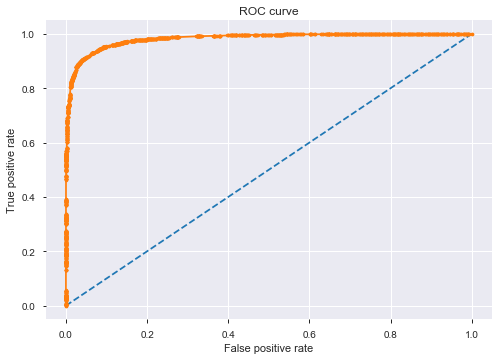

############# Test dataset  #########################################
Test confusion matrix
[[3662  270]
 [ 745 9441]]
[[0.93133266 0.06866734]
 [0.0731396  0.9268604 ]]
auc 0.9816998312566328
gini 0.9633996625132657
acc 0.9281059640175662
f1macro 0.9136350261166026
Nsample 14118
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3932
           1       0.97      0.93      0.95     10186

   micro avg       0.93      0.93      0.93     14118
   macro avg       0.90      0.93      0.91     14118
weighted avg       0.93      0.93      0.93     14118



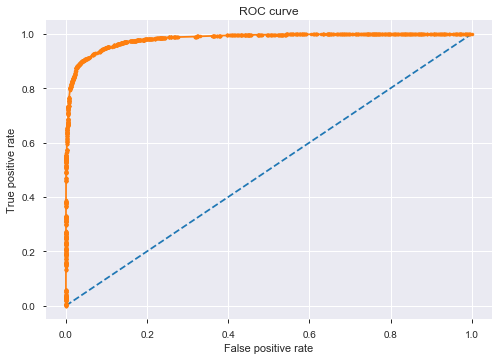

In [43]:
clf_log, dd = sk_model_eval_classification(clf_log, 1,
                                           Xtrain, ytrain, Xtest, ytest)



In [92]:
sk_model_eval_classification_cv(clf_log,  X, yy, test_size=0.5, ncv=3 )



############# CV-0######################################
############# Train dataset  ####################################
Test confusion matrix
[[3737  223]
 [ 703 9454]]
[[0.94368687 0.05631313]
 [0.06921335 0.93078665]]
auc 0.9833729512313248
gini 0.9667459024626497
acc 0.9344053269108168
f1macro 0.9215371992297978
Nsample 14117
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3960
           1       0.98      0.93      0.95     10157

   micro avg       0.93      0.93      0.93     14117
   macro avg       0.91      0.94      0.92     14117
weighted avg       0.94      0.93      0.94     14117

############# Test dataset  #########################################
Test confusion matrix
[[3741  272]
 [ 758 9347]]
[[0.93222028 0.06777972]
 [0.07501237 0.92498763]]
auc 0.9805119383774135
gini 0.9610238767548269
acc 0.9270434905794022
f1macro 0.9133868580013205
Nsample 14118
              precision    recall  f1-score   support

   

{0: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False),
 1: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False),
 2: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False)}

In [44]:
clf_log_feat = sk_feature_impt_logis(clf_log, colX)
clf_log_feat 



,feature,coef,coef_abs,rank
15,name_trigram_term_bin_0,-2.192481,2.192481,0
126,phone_trigram_bin_3,2.065261,2.065261,1
87,street_trigram_term_bin_0,-2.029708,2.029708,2
5,name_trigram_simple_bin_0,-1.915403,1.915403,3
9,name_trigram_simple_bin_4,1.788609,1.788609,4
28,city_trigram_simple_bin_1,1.572522,1.572522,5
124,phone_trigram_bin_1,-1.379402,1.379402,6
18,name_trigram_term_bin_3,1.368182,1.368182,7
153,phone_equality_2,1.358926,1.358926,8
127,phone_trigram_bin_4,1.358926,1.358926,9


In [44]:

1

1

In [96]:
### Light GBM
clf_lgb = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l2', 
                         max_depth= 15, n_estimators = 50, objective= 'binary',
                         num_leaves = 38, njobs= -1 )



In [97]:
clf_lgb, dd_lgb = sk_model_eval_classification(clf_lgb, 1,
                                           Xtrain, ytrain, Xtest, ytest)


############# Train dataset  ####################################
Test confusion matrix
[[3692  349]
 [ 336 9740]]
[[0.91363524 0.08636476]
 [0.03334657 0.96665343]]
auc 0.989414660409642
gini 0.978829320819284
acc 0.9514769426932068
f1macro 0.9405687254152499
Nsample 14117
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4041
           1       0.97      0.97      0.97     10076

   micro avg       0.95      0.95      0.95     14117
   macro avg       0.94      0.94      0.94     14117
weighted avg       0.95      0.95      0.95     14117

############# Test dataset  #########################################
Test confusion matrix
[[3524  408]
 [ 398 9788]]
[[0.89623601 0.10376399]
 [0.03907324 0.96092676]]
auc 0.9844837073165471
gini 0.9689674146330942
acc 0.9429097605893186
f1macro 0.9289162181852965
Nsample 14118
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3932
        

In [98]:
import shap
shap.initjs()

dftest = pd.DataFrame( columns=colall, data=Xtest)

explainer = shap.TreeExplainer( clf_lgb )
shap_values = explainer.shap_values(  dftest )

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], dftest.iloc[0,:] )



In [ ]:
# visualize the training set predictions
# shap.force_plot(explainer.expected_value, shap_values, dftest)

# Plot summary_plot as barplot:
#shap.summary_plot(shap_values, Xtest, plot_type='bar')



     value                            feature
159     82   street_number_levenshtein_bin_-1
158     66          street_trigram_term_bin_0
157     66            phone_levenshtein_bin_4
156     47        street_number_trigram_bin_1
155     47            name_trigram_term_bin_0
154     46           phone_levenshtein_bin_-1
153     44                phone_trigram_bin_4
152     42        street_number_trigram_bin_4
151     42            name_trigram_term_bin_1
150     40                phone_trigram_bin_1
149     40          name_trigram_simple_bin_0
148     36                   phone_equality_1
147     34          name_trigram_simple_bin_1
146     33    street_number_levenshtein_bin_4
145     33          name_trigram_simple_bin_4
144     32                phone_trigram_bin_3
143     32        name_levenshtein_term_bin_3
142     31        name_levenshtein_term_bin_1
141     31     city_levenshtein_simple_bin_-1
139     25           street_number_equality_0
140     25  website_levenshtein_si

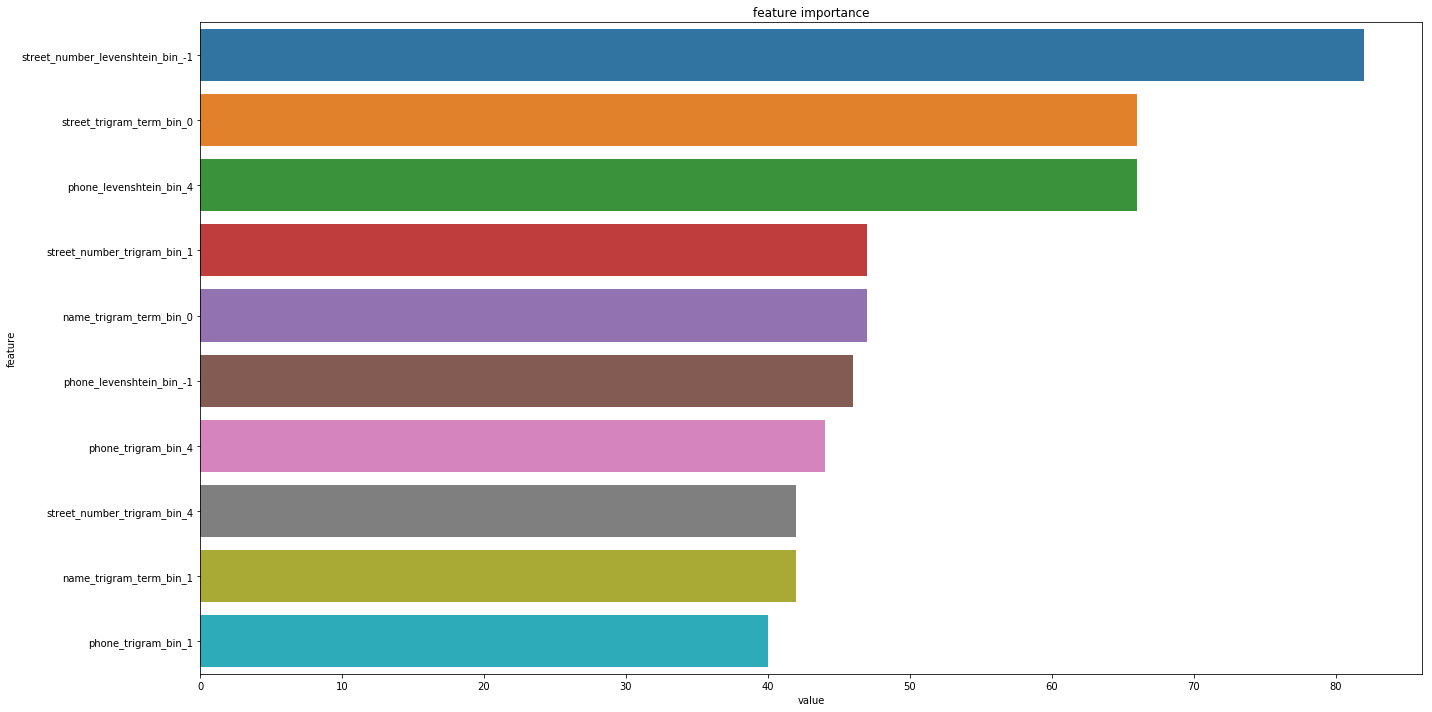

<Figure size 432x288 with 0 Axes>

In [112]:
lgb_feature_imp = pd.DataFrame(sorted(zip(clf_lgb.feature_importances_, colall)), columns=['value','feature'])
lgb_feature_imp = lgb_feature_imp.sort_values( "value", ascending=0 )
print(lgb_feature_imp )


plotbar(lgb_feature_imp.iloc[:10,:], colname=["value", "feature"],  
        title="feature importance", savefile="lgb_feature_imp.png") 




In [118]:
kf = StratifiedKFold(n_splits=3, shuffle=True)
# partially based on https://www.kaggle.com/c0conuts/xgb-k-folds-fastai-pca
clf_list = []
for itrain, itest in kf.split(X, yy):
    print("###")
    Xtrain, Xval = X[ itrain ], X[ itest ]
    ytrain, yval = yy[ itrain ], yy[ itest ]
    clf_lgb.fit(Xtrain, ytrain, eval_set=[(Xval, yval)], 
            early_stopping_rounds=20)
    
    
    clf_list.append( clf_lgb)
    
    




###
[1]	valid_0's l2: 0.165319
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l2: 0.137843
[3]	valid_0's l2: 0.117217
[4]	valid_0's l2: 0.101394
[5]	valid_0's l2: 0.089279
[6]	valid_0's l2: 0.0798809
[7]	valid_0's l2: 0.0726838
[8]	valid_0's l2: 0.0668424
[9]	valid_0's l2: 0.0622568
[10]	valid_0's l2: 0.0587646
[11]	valid_0's l2: 0.0559598
[12]	valid_0's l2: 0.0536837
[13]	valid_0's l2: 0.0519165
[14]	valid_0's l2: 0.0505175
[15]	valid_0's l2: 0.0494609
[16]	valid_0's l2: 0.048552
[17]	valid_0's l2: 0.0476837
[18]	valid_0's l2: 0.0470894
[19]	valid_0's l2: 0.0464756
[20]	valid_0's l2: 0.0460666
[21]	valid_0's l2: 0.0456916
[22]	valid_0's l2: 0.0454429
[23]	valid_0's l2: 0.0452049
[24]	valid_0's l2: 0.0448836
[25]	valid_0's l2: 0.044704
[26]	valid_0's l2: 0.044557
[27]	valid_0's l2: 0.0444133
[28]	valid_0's l2: 0.0441854
[29]	valid_0's l2: 0.0440899
[30]	valid_0's l2: 0.0439389
[31]	valid_0's l2: 0.0438229
[32]	valid_0's l2: 0.0437429
[33]	valid_0's l2: 0.04

0
############# Test dataset  #########################################
Test confusion matrix
[[3521  411]
 [ 290 9896]]
[[0.89547304 0.10452696]
 [0.02847045 0.97152955]]
auc 0.9877143098689902
gini 0.9754286197379805
acc 0.950347074656467
f1macro 0.9376299063421794
Nsample 14118
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3932
           1       0.96      0.97      0.97     10186

   micro avg       0.95      0.95      0.95     14118
   macro avg       0.94      0.93      0.94     14118
weighted avg       0.95      0.95      0.95     14118



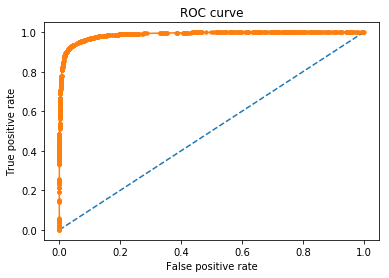

1
############# Test dataset  #########################################
Test confusion matrix
[[3521  411]
 [ 290 9896]]
[[0.89547304 0.10452696]
 [0.02847045 0.97152955]]
auc 0.9877143098689902
gini 0.9754286197379805
acc 0.950347074656467
f1macro 0.9376299063421794
Nsample 14118
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3932
           1       0.96      0.97      0.97     10186

   micro avg       0.95      0.95      0.95     14118
   macro avg       0.94      0.93      0.94     14118
weighted avg       0.95      0.95      0.95     14118



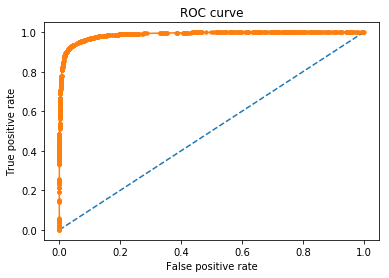

2
############# Test dataset  #########################################
Test confusion matrix
[[3521  411]
 [ 290 9896]]
[[0.89547304 0.10452696]
 [0.02847045 0.97152955]]
auc 0.9877143098689902
gini 0.9754286197379805
acc 0.950347074656467
f1macro 0.9376299063421794
Nsample 14118
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3932
           1       0.96      0.97      0.97     10186

   micro avg       0.95      0.95      0.95     14118
   macro avg       0.94      0.93      0.94     14118
weighted avg       0.95      0.95      0.95     14118



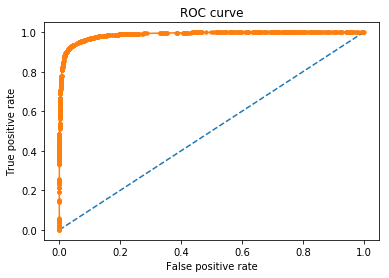

In [122]:
for i, clfi in enumerate( clf_list) :
    print(i)
    clf_lgbi, dd_lgbi = sk_model_eval_classification(clfi, 0,
                                               Xtrain, ytrain, Xtest, ytest)
    

In [4]:
def np_find_indice(v, x) :
  for i, j in enumerate(v):
    if j == x :
       return i
  return -1




def col_getnumpy_indice(colall, colcat) :
    return [  np_find_indice(colall, x)  for x in colcat ]



In [7]:
#### CatbOost
import catboost as cb

colcat_idx = col_getnumpy_indice(colall, colcat)

clf_cb = cb.CatBoostClassifier( iterations=1000, depth=8,
                          learning_rate=0.02, loss_function='Logloss',
                          eval_metric='AUC', random_seed=42,
                          rsm = 0.2, # features subsample 
                          od_type = 'Iter', # early stopping odwait = 100, # early stopping
                          verbose = 100,l2_leaf_reg = 20, # regularisation 
)






In [8]:
#clf_cb, dd_cb = sk_model_eval_classification(clf_cb, 1,
#                                               Xtrain, ytrain, Xtest, ytest)


clf_cb.fit(Xtrain, ytrain,
                 eval_set=(Xtest, ytest),
                 cat_features= np.arange(0, Xtrain.shape[1]),
                 use_best_model=True)


NameError: name 'Xtrain' is not defined

############# Train dataset  ####################################
Test confusion matrix
[[ 4621   695]
 [  469 13039]]
[[0.8692626  0.1307374 ]
 [0.03472017 0.96527983]]
auc 0.9821607052020339
gini 0.9643214104040678
acc 0.9381640458988525
f1macro 0.9227066582401655
Nsample 18824
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5316
           1       0.95      0.97      0.96     13508

   micro avg       0.94      0.94      0.94     18824
   macro avg       0.93      0.92      0.92     18824
weighted avg       0.94      0.94      0.94     18824



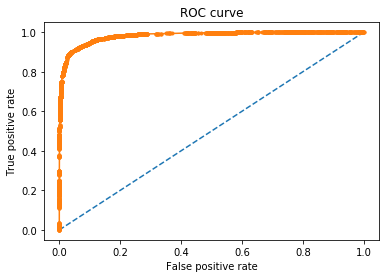

############# Test dataset  #########################################
Test confusion matrix
[[3413  519]
 [ 382 9804]]
[[0.8680061  0.1319939 ]
 [0.03750245 0.96249755]]
auc 0.981227612491084
gini 0.9624552249821681
acc 0.9361807621476129
f1macro 0.9197319761191183
Nsample 14118
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      3932
           1       0.95      0.96      0.96     10186

   micro avg       0.94      0.94      0.94     14118
   macro avg       0.92      0.92      0.92     14118
weighted avg       0.94      0.94      0.94     14118



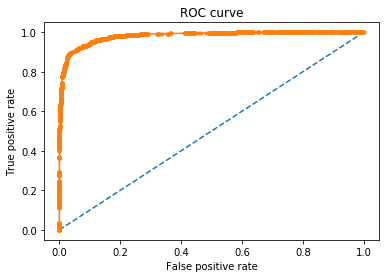

In [123]:
# Fitting a SVM
clf_svc = SVC(C=1.0, probability=True) # since we need probabilities

clf_svc, dd_svc = sk_model_eval_classification(clf_svc, 1,
                                               Xtrain, ytrain, Xtest, ytest)



In [54]:
### MLP Classifier
from sklearn.neural_network import MLPClassifier

clf_nn = MLPClassifier( hidden_layer_sizes=(50,), max_iter=80, alpha=1e-4,
                        activation="relu",
                        solver='adam', verbose=10, tol=1e-4, random_state=1,
                        learning_rate_init= 0.1, early_stopping=True, validation_fraction=0.2 )
                       
                     

############# Train dataset  ####################################
Iteration 1, loss = 0.30374545
Validation score: 0.919618
Iteration 2, loss = 0.15422258
Validation score: 0.922450
Iteration 3, loss = 0.15042476
Validation score: 0.924221
Iteration 4, loss = 0.14651006
Validation score: 0.927408
Iteration 5, loss = 0.14387765
Validation score: 0.928116
Iteration 6, loss = 0.13938971
Validation score: 0.925992
Iteration 7, loss = 0.13431603
Validation score: 0.924221
Iteration 8, loss = 0.13630725
Validation score: 0.932011
Iteration 9, loss = 0.13620662
Validation score: 0.926346
Iteration 10, loss = 0.13224484
Validation score: 0.921388
Iteration 11, loss = 0.13236208
Validation score: 0.921034
Iteration 12, loss = 0.12917632
Validation score: 0.929533
Iteration 13, loss = 0.12991413
Validation score: 0.926346
Iteration 14, loss = 0.12787154
Validation score: 0.928824
Iteration 15, loss = 0.12892515
Validation score: 0.920326
Iteration 16, loss = 0.12838998
Validation score: 0.926346

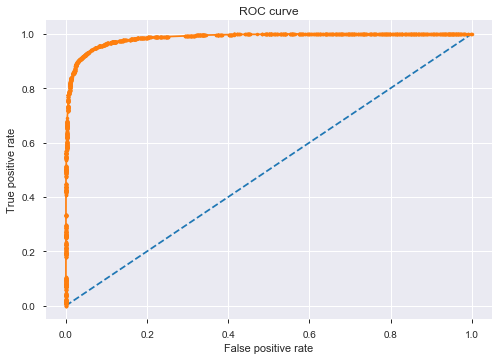

############# Test dataset  #########################################
Test confusion matrix
[[3490  442]
 [ 417 9769]]
[[0.88758901 0.11241099]
 [0.04093854 0.95906146]]
auc 0.9810311896587163
gini 0.9620623793174325
acc 0.9391556877744723
f1macro 0.9241528300059735
Nsample 14118
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3932
           1       0.96      0.96      0.96     10186

   micro avg       0.94      0.94      0.94     14118
   macro avg       0.92      0.92      0.92     14118
weighted avg       0.94      0.94      0.94     14118



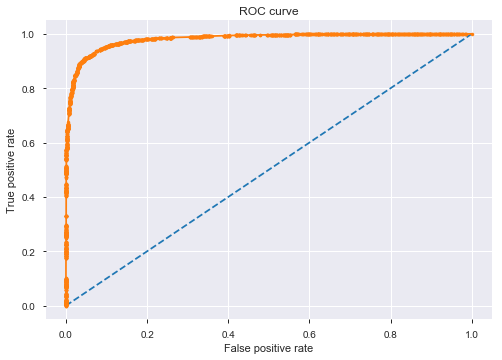

In [55]:
clf_nn, dd_nn = sk_model_eval_classification(clf_nn, 1,
                                           Xtrain, ytrain, Xtest, ytest)



In [ ]:
### Feature Selection (reduce over-fitting)
   #Pre model feature selection (sometimes some features are useful even with low variance....)
   #Post model feature selection




In [59]:
### Model independant Selection
colX_kbest= sk_model_eval_feature(clf_nn,  method="f_classif", colname= colX, kbest=50,
                                 Xtrain= Xtrain, ytrain= ytrain)


print( colX_kbest )

['name_levenshtein_simple_bin_0', 'name_levenshtein_simple_bin_1', 'name_levenshtein_simple_bin_4', 'name_trigram_simple_bin_0', 'name_trigram_simple_bin_3', 'name_trigram_simple_bin_4', 'name_levenshtein_term_bin_0', 'name_levenshtein_term_bin_1', 'name_levenshtein_term_bin_4', 'name_trigram_term_bin_0', 'name_trigram_term_bin_3', 'name_trigram_term_bin_4', 'city_levenshtein_simple_bin_-1', 'city_levenshtein_simple_bin_4', 'city_trigram_simple_bin_-1', 'city_trigram_simple_bin_4', 'city_levenshtein_term_bin_-1', 'city_levenshtein_term_bin_4', 'city_trigram_term_bin_-1', 'city_trigram_term_bin_4', 'zip_levenshtein_simple_bin_-1', 'zip_levenshtein_simple_bin_4', 'zip_trigram_simple_bin_-1', 'zip_levenshtein_term_bin_-1', 'zip_levenshtein_term_bin_4', 'zip_trigram_term_bin_-1', 'zip_trigram_term_bin_1', 'street_levenshtein_simple_bin_0', 'street_levenshtein_simple_bin_1', 'street_trigram_simple_bin_0', 'street_trigram_simple_bin_1', 'street_levenshtein_term_bin_0', 'street_levenshtein_te

# Ensembling 

In [54]:
from sklearn.ensemble import VotingClassifier

clf_list = []
clf_list.append( ("clf_log", clf_log) )
clf_list.append( ("clf_lgb", clf_lgb) )
clf_list.append( ("clf_svc", clf_svc) )


clf_ens1 = VotingClassifier(clf_list, voting= "soft")  #Soft is required
print(clf_ens1)




VotingClassifier(estimators=[('clf_log', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)), ('cl...bf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)


In [55]:
sk_model_eval_classification(clf_ens1, 1,
                                           Xtrain, ytrain, Xtest, ytest)


############# Train dataset  ####################################
Test confusion matrix
[[3627  414]
 [ 452 9624]]
[[0.89755011 0.10244989]
 [0.04485907 0.95514093]]
auc 0.9844820050614586
gini 0.9689640101229171
acc 0.9386555217114118
f1macro 0.9251475824254949
Nsample 14117
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      4041
           1       0.96      0.96      0.96     10076

   micro avg       0.94      0.94      0.94     14117
   macro avg       0.92      0.93      0.93     14117
weighted avg       0.94      0.94      0.94     14117

############# Test dataset  #########################################
Test confusion matrix
[[3504  428]
 [ 495 9691]]
[[0.89114954 0.10885046]
 [0.04859611 0.95140389]]
auc 0.9831839259758323
gini 0.9663678519516645
acc 0.934622467771639
f1macro 0.9190822245462287
Nsample 14118
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      3932
       

(VotingClassifier(estimators=[('clf_log', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
           solver='warn', tol=0.0001, verbose=0, warm_start=False)), ('cl...bf', max_iter=-1, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False))],
          flatten_transform=None, n_jobs=None, voting='soft', weights=None),
 {'ytest_pred': array([ 1, -1, -1, ...,  1,  1,  1], dtype=int64)})

# Predict values

In [129]:
dft = pd.read_csv(folder + '/data/address_matching_data.csv')

In [130]:
#####
dft = dft.replace("?",  np.nan)








In [131]:
dft[colcat].head(3)

,phone_equality,fax_equality,street_number_equality
0,m,m,s
1,m,m,s
2,s,m,s


In [132]:
#### Pre-processing  cat :  New Cat are discard, Missing one are included
for col in colcat :
    try :
       dft[col] = dft[col].apply(lambda x : colcat_map["cat_map"][col].get(x)  )
    except Exception as e:
       print(col, e) 
    
    
dft_colcat_hot = pd_col_to_onehot( dft[colcat], colcat)    
    

for x in colcat_hot  :
     if not x in dft_colcat_hot.columns :
        dft_colcat_hot[x] = 0
        print(x, "added")    

        
dft_colcat_hot[colcat_hot].head(5)    

        

phone_equality 3 (28235, 3)
fax_equality 3 (28235, 5)
street_number_equality 3 (28235, 7)


In [133]:
dft_colcat_hot.head(4)

,phone_equality_0,phone_equality_1,phone_equality_2,fax_equality_0,fax_equality_1,fax_equality_2,street_number_equality_0,street_number_equality_1,street_number_equality_2
0,1,0,0,1,0,0,0,0,1
1,1,0,0,1,0,0,0,0,1
2,0,0,1,1,0,0,0,0,1
3,0,0,1,1,0,0,0,1,0


In [151]:
#### Pre-processing num :  REUSE Colnum_map and Pad the missing values
dft_numbin, _ = pd_colnum_tocat(dft[colnum], colname=colnum, colexclude=None,
                                 colbinmap = colnum_map,
                                 bins=0, suffix="_bin", method="")






name_levenshtein_simple
[-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]
                            name_levenshtein_simple                      
                                               mean  min       max   size
name_levenshtein_simple_bin                                              
0                                          0.133234  0.0  0.199916   3244
1                                          0.284679  0.2  0.399802   4352
2                                          0.495519  0.4  0.599206   4713
3                                          0.679888  0.6  0.797778   4992
4                                          0.945298  0.8  1.000000  10934
name_trigram_simple
[-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]
                        name_trigram_simple                      
                                       mean  min       max   size
name_trigram_simple_bin                                          
0                                  0.034203  0.0  0.199356   6913


 4                                             0.958354  0.8  1.000000   4186
street_trigram_simple
[-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]
                          street_trigram_simple                      
                                           mean  min       max   size
street_trigram_simple_bin                                            
-1                                          NaN  NaN       NaN  19997
 0                                     0.038069  0.0  0.198485   1669
 1                                     0.281841  0.2  0.399669   1020
 2                                     0.499309  0.4  0.596875    575
 3                                     0.706532  0.6  0.793651   1026
 4                                     0.958941  0.8  1.000000   3948
street_levenshtein_term
[-0.0001, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]
                            street_levenshtein_term                      
                                               mean  min       max   siz

In [157]:
dft_numbin.head(5)

,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,zip_trigram_simple,...,website_levenshtein_simple_bin,website_trigram_simple_bin,website_levenshtein_term_bin,website_trigram_term_bin,phone_levenshtein_bin,phone_trigram_bin,fax_levenshtein_bin,fax_trigram_bin,street_number_levenshtein_bin,street_number_trigram_bin
0,0.666667,0.666667,0.400000,0.526316,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-1,-1,-1,-1,-1,-1,-1,4,4
1,0.666667,0.666667,0.411765,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-1,-1,-1,-1,-1,-1,-1,4,4
2,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,-1,-1,-1,-1,-1,4,-1,-1,4,4
3,0.565476,0.333333,0.260870,0.189189,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-1,-1,-1,-1,4,-1,-1,0,0
4,0.666667,0.666667,0.500000,0.518519,1.0,1.0,1.0,1.0,1.0,1.0,...,-1,-1,-1,-1,-1,4,-1,-1,4,4


In [167]:
dft_num_hot = pd_col_to_onehot( dft_numbin[colnum_bin], colname=colnum_bin, 
                                   colonehot = colnum_hot)
    

name_levenshtein_simple_bin 5 (28235, 26)
name_trigram_simple_bin 5 (28235, 30)
name_levenshtein_term_bin 5 (28235, 34)
name_trigram_term_bin 5 (28235, 38)
city_levenshtein_simple_bin 6 (28235, 42)
city_trigram_simple_bin 6 (28235, 47)
city_levenshtein_term_bin 6 (28235, 52)
city_trigram_term_bin 6 (28235, 57)
zip_levenshtein_simple_bin 6 (28235, 62)
zip_trigram_simple_bin 6 (28235, 67)
zip_levenshtein_term_bin 6 (28235, 72)
zip_trigram_term_bin 6 (28235, 77)
street_levenshtein_simple_bin 6 (28235, 82)
street_trigram_simple_bin 6 (28235, 87)
street_levenshtein_term_bin 6 (28235, 92)
street_trigram_term_bin 6 (28235, 97)
website_levenshtein_simple_bin 6 (28235, 102)
website_trigram_simple_bin 6 (28235, 107)
website_levenshtein_term_bin 6 (28235, 112)
website_trigram_term_bin 6 (28235, 117)
phone_levenshtein_bin 6 (28235, 122)
phone_trigram_bin 6 (28235, 127)
fax_levenshtein_bin 6 (28235, 132)
fax_trigram_bin 6 (28235, 137)
street_number_levenshtein_bin 6 (28235, 142)
street_number_trigr

In [165]:
dft_num_hot.head(5)



,name_levenshtein_simple_bin_0,name_levenshtein_simple_bin_1,name_levenshtein_simple_bin_2,name_levenshtein_simple_bin_3,name_levenshtein_simple_bin_4,name_trigram_simple_bin_0,name_trigram_simple_bin_1,name_trigram_simple_bin_2,name_trigram_simple_bin_3,name_trigram_simple_bin_4,...,street_number_levenshtein_bin_0,street_number_levenshtein_bin_1,street_number_levenshtein_bin_2,street_number_levenshtein_bin_3,street_number_levenshtein_bin_4,street_number_trigram_bin_-1,street_number_trigram_bin_0,street_number_trigram_bin_1,street_number_trigram_bin_2,street_number_trigram_bin_4
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [168]:
print( dft_num_hot.shape,  dfnum_hot.shape )



(28235, 151) (28235, 151)


(28235, 151) (28235, 151)


In [169]:
#### Train 
X= pd.concat(( dft_num_hot, dfcat_hot ), axis=1).values

print(X.shape)



(28235, 160)


In [175]:
dft[coly] = clf_ens1.predict(X)

In [176]:
dft.head(5)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
0,1204#1207,0.666667,0.666667,0.400000,0.526316,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,0,0,2,1
1,1272#1279,0.666667,0.666667,0.411765,0.444444,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,0,0,2,1
2,6258#6259,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,...,1.0,1.0,NaN,NaN,1.0,1.0,2,0,2,1
3,16076#16077,0.565476,0.333333,0.260870,0.189189,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,0.0,0.0,2,0,1,-1
4,2666#2671,0.666667,0.666667,0.500000,0.518519,1,1,1,1,1,...,1.0,1.0,NaN,NaN,1.0,1.0,2,0,2,1


In [177]:
dft.groupby(coly).agg({"id" : "count"})

,id
is_match,
-1,9241
1,18994


0

In [183]:
dft[[ "id", "is_match"  ]].to_csv("adress_pred.csv" , index=False, mode="w")

0

In [34]:
### NA handling
df_ = train_df.append(test_df)
use_columns = [s for s in df_.columns if s not in ['id', 'is_match']]
df = df_[use_columns]

for c in df.columns:
    if df[c].dtype=='object':
        df.loc[df[c]=='?', c]=0
    else:
        print('skip ', c)


skip  name_levenshtein_simple
skip  name_trigram_simple
skip  name_levenshtein_term
skip  name_trigram_term


In [35]:
### Encode numerical into Category to handle NA distribution



In [179]:
0




0

0

In [180]:
0


0

In [ ]:
"""
Sparse Logistics


"""

In [181]:
0

0

In [46]:
### NO Null Features
len(df_featlogis[df_featlogis["coef_abs"] > 0.0 ])

69

In [ ]:

preds = clf.predict(test_df[feats])
preds[preds==0] = -1


In [ ]:
test_df = pd.read_csv('./data/address_matching_test.csv')
test_df['is_match'] = preds.astype(int)
test_df = test_df.reset_index()
test_df[['id', 'is_match']].to_csv('result.csv', index=False)


